In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVR

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import LeaveOneOut

**DATASET PREPARATION**

In [3]:
dataset = pd.read_excel('modified_dataset.xlsx')
dataset.head()

,Sample No.,SiO2,Al2O3,Fe2O3,MnO,MgO,CaO,Na2O,K2O,TiO2,...,Band215,Band216,Band217,Band218,Band219,Band220,Band221,Band222,Band223,Band224
0,2,71.45,11.66,2.49,0.05,1.54,4.43,1.78,1.86,0.59,...,5.346875,4.703125,4.881250,4.362500,3.712500,3.953125,3.571875,3.046875,3.184375,3.831250
1,3,70.02,11.48,2.61,0.05,1.35,3.58,2.40,1.83,0.53,...,5.856250,5.090625,5.325000,4.762500,3.996875,4.137500,3.818750,3.293750,2.921875,3.206250
2,4,70.24,12.71,3.28,0.06,1.89,1.71,1.12,1.94,0.70,...,5.131250,4.415625,4.596875,4.096875,3.515625,3.703125,3.612500,3.193750,2.806250,2.934375
3,5,76.58,10.22,2.50,0.05,1.15,1.67,1.41,1.94,0.55,...,5.165625,4.512500,4.725000,4.215625,3.500000,3.728125,3.412500,2.862500,2.528125,2.812500
4,10,81.81,6.37,2.04,0.05,0.68,2.07,0.91,1.61,0.48,...,5.068750,4.381250,4.781250,4.362500,3.700000,3.903125,3.459375,2.865625,2.628125,2.884375


In [4]:
dataset.shape

(91, 209)

In [5]:
Band_data = dataset.iloc[:,11:]
concentration_data = dataset.iloc[:,1:11]

In [5]:
print("Band Data Shape:", Band_data.shape)
print("Concentration Data Shape:", concentration_data.shape)

Band Data Shape: (91, 198)
Concentration Data Shape: (91, 10)


**MIN-MAX NORMALIZATION OF BAND DATA**

In [6]:
for column in Band_data.columns[0:]:
  Band_data[column] = (Band_data[column] - Band_data[column].min()) / (Band_data[column].max() - Band_data[column].min())

**PRINCIPAL COMPONENT ANALYSIS OF BAND DATA**

In [7]:
def myPCA(data, num_principal_components = None):
    data_centered = data - np.mean(data, axis=0)
    cov_matrix = np.cov(data_centered.T)
    eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
    sorted_indices = np.argsort(eigenvalues)[::-1]
    sorted_eigenvectors = eigenvectors[:, sorted_indices]
    sorted_eigenvalues = eigenvalues[sorted_indices]
    if num_principal_components is None:
        return sorted_eigenvectors, sorted_eigenvalues
    else:
        principal_components = sorted_eigenvectors[:, :num_principal_components]
        principal_values = sorted_eigenvalues[:num_principal_components]
        return principal_components, principal_values

In [8]:
pc, ev = myPCA(Band_data, None)

In [9]:
vp = []
sum = 0
for i in range(len(ev)):
  sum += ev[i]
  res = sum / np.sum(ev)
  vp.append(res)

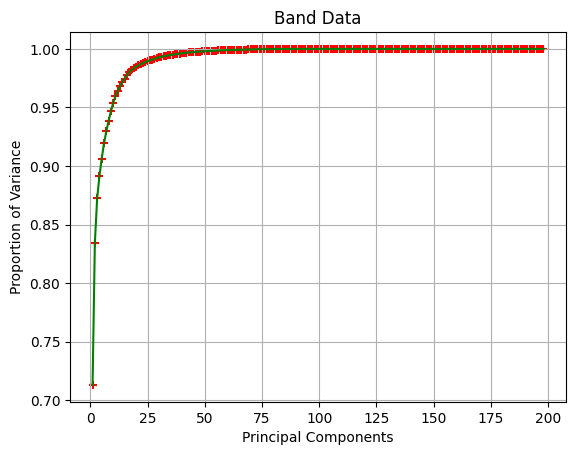

In [10]:
plt.plot(range(1, pc.shape[1]+1), vp, c='g')
plt.scatter(range(1, pc.shape[1]+1), vp, c='r', marker='+')
plt.xlabel('Principal Components')
plt.ylabel('Proportion of Variance')
plt.title("Band Data")
plt.grid(True)
plt.show()

In [11]:
variance_prop = ev / np.sum(ev)
cvp = np.cumsum(variance_prop)
k = np.argmax(cvp >= 0.95) + 1
print(f"The number of components k = {k} with the coverage of {cvp[k]*100} %")

The number of components k = 10 with the coverage of 95.96422722322758 %


In [12]:
optimal_components = pc[:, :k]

In [13]:
x = np.dot(Band_data, optimal_components)
print("Reduced Band Data Shape:", x.shape)

Reduced Band Data Shape: (91, 10)


**SVR**

Mean Squared Error: 10.496242861662752


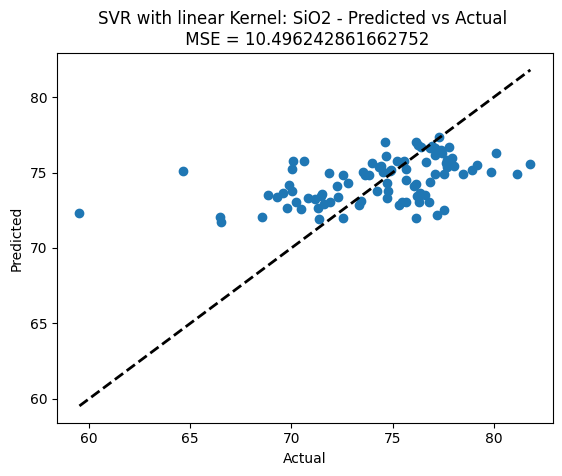

Mean Squared Error: 1.896618332948513


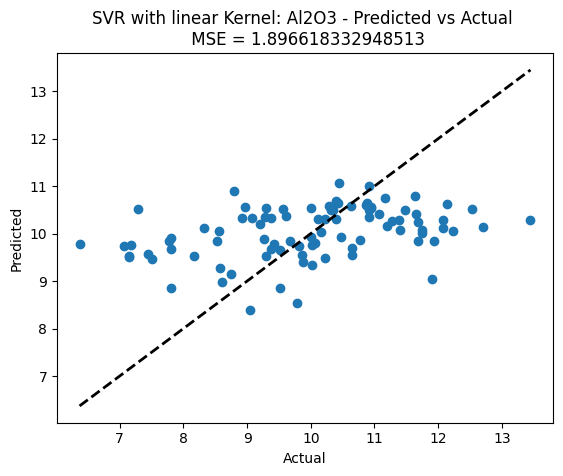

Mean Squared Error: 0.26197333623718905


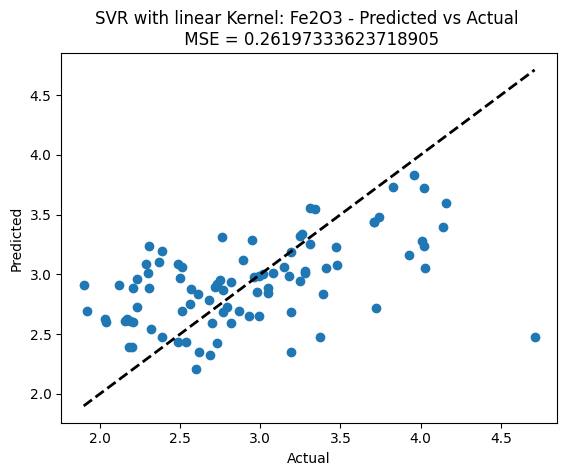

Mean Squared Error: 4.233706893015122e-05


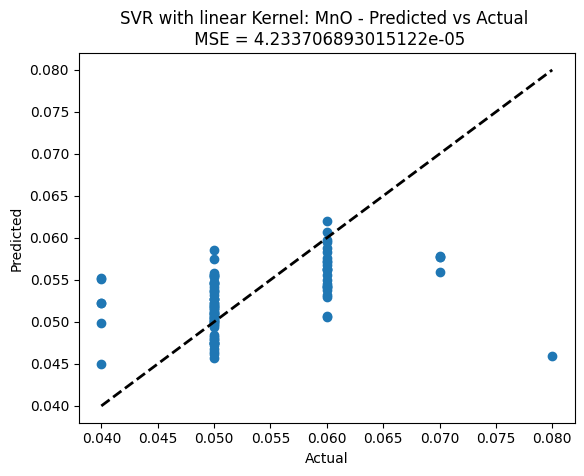

Mean Squared Error: 0.094851414816669


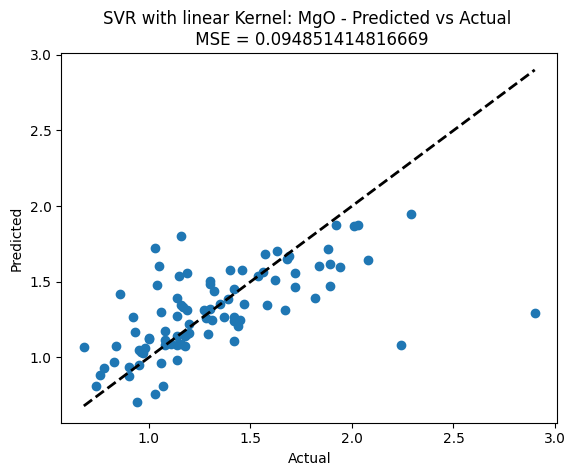

Mean Squared Error: 0.8918873988671818


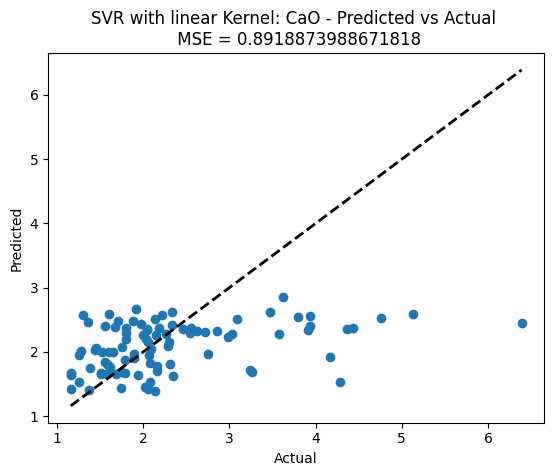

Mean Squared Error: 0.5599105770254612


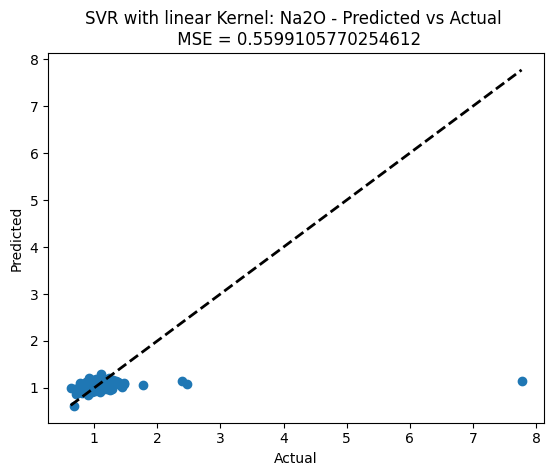

Mean Squared Error: 0.03879199017196694


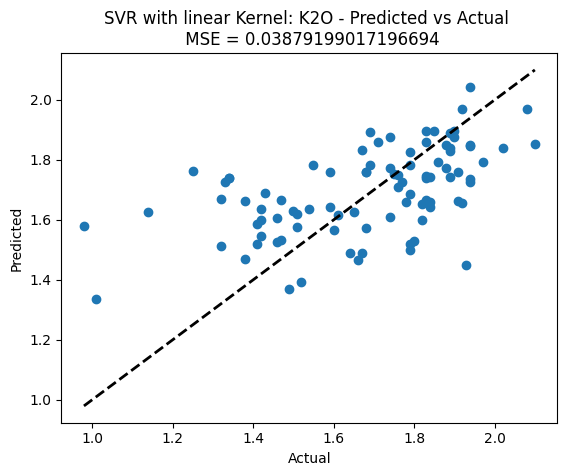

Mean Squared Error: 0.009300593180346858


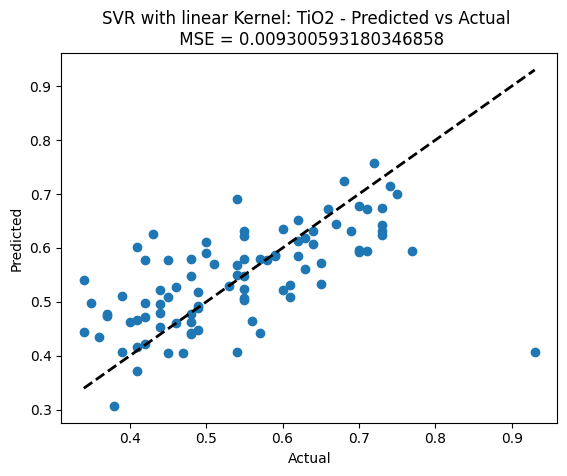

Mean Squared Error: 0.0003369813521503849


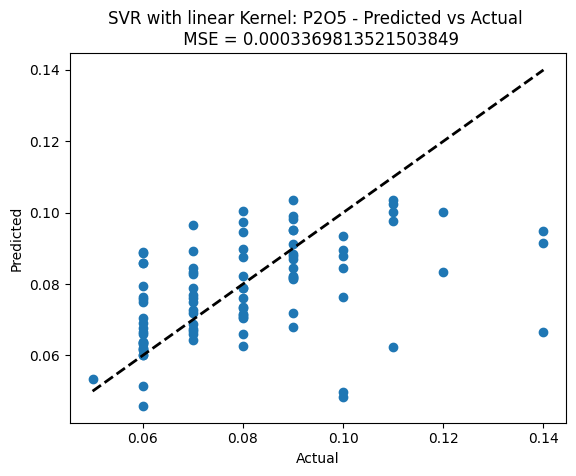

In [68]:
for col in concentration_data.columns[:]:
    y = concentration_data[col].values

    kernel = 'linear'
    svr = SVR(kernel=kernel)
    param_grid = {'C': [0.1, 1, 10], 'epsilon': [0.1, 0.01, 0.001]}

    grid_search = GridSearchCV(svr, param_grid, cv=5)
    grid_search.fit(x, y)
    best_params = grid_search.best_params_

    best_C = best_params['C']
    best_epsilon = best_params['epsilon']
    best_svr = SVR(kernel=kernel, C=best_C, epsilon=best_epsilon)

    loo = LeaveOneOut()
    y_pred_list = []
    for train_index, test_index in loo.split(x):
        X_train, X_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]
        best_svr.fit(X_train, y_train)
        y_pred = best_svr.predict(X_test)
        y_pred_list.append(y_pred)

    mse = mean_squared_error(y, y_pred_list)
    print("Mean Squared Error:", mse)

    plt.scatter(y, y_pred_list)
    plt.plot([min(y), max(y)], [min(y), max(y)], 'k--', lw=2)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(f'SVR with {kernel} Kernel: {col} - Predicted vs Actual \n MSE = {mse}')
    plt.show()



Mean Squared Error: 10.217847538976564


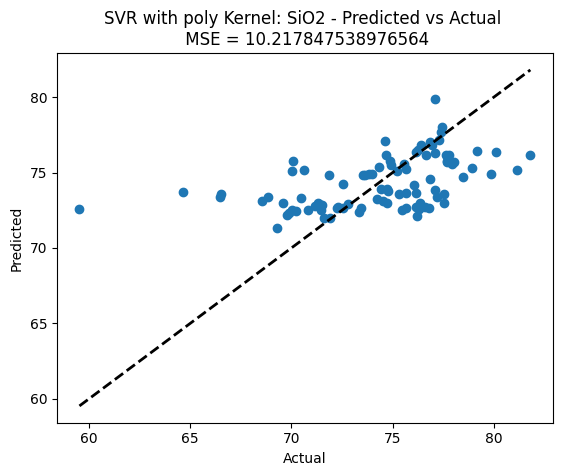

Mean Squared Error: 2.057629377215181


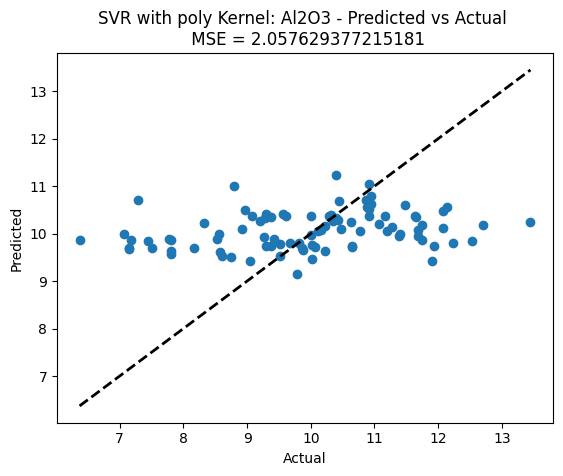

Mean Squared Error: 0.30087011583945833


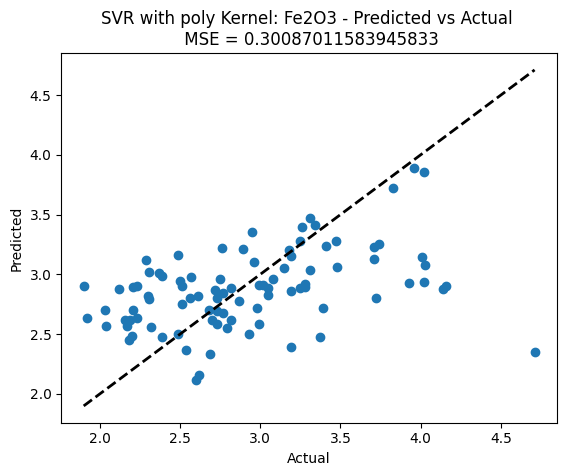

Mean Squared Error: 4.509392347157609e-05


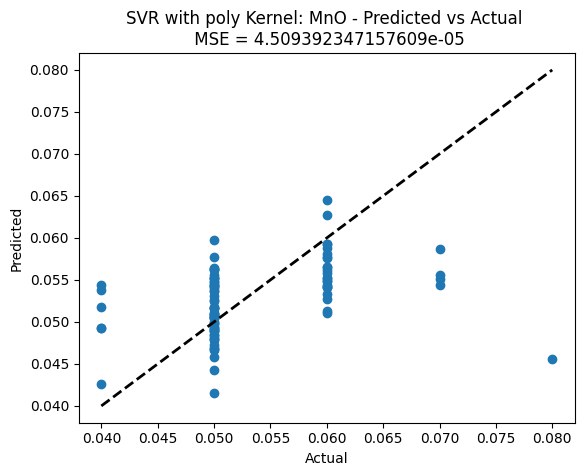

Mean Squared Error: 0.11645505051011895


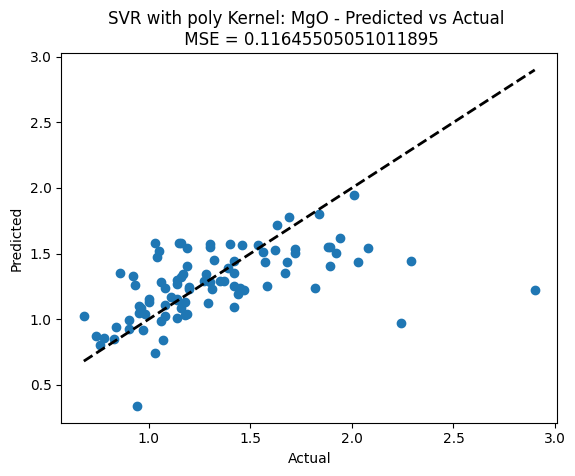

Mean Squared Error: 0.9003790543593431


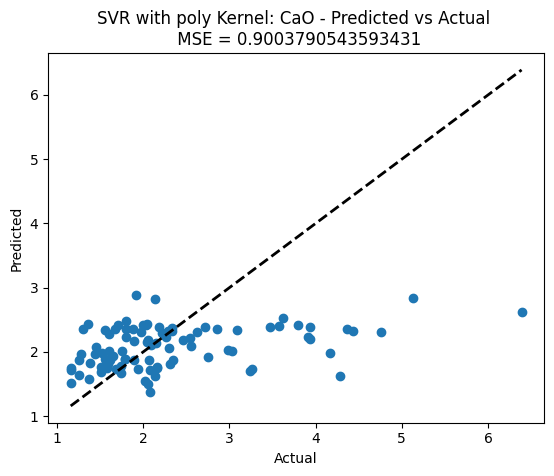

Mean Squared Error: 0.5482885780960264


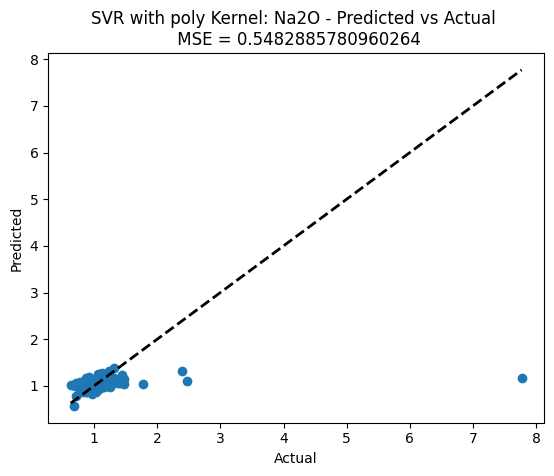

Mean Squared Error: 0.039600973315666144


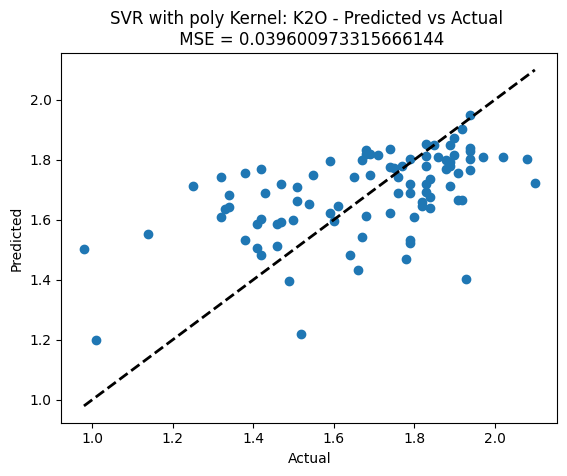

Mean Squared Error: 0.009116745283038503


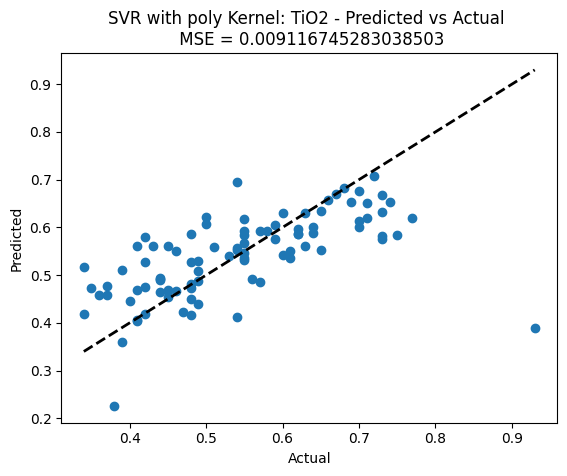

Mean Squared Error: 0.00033161990037307857


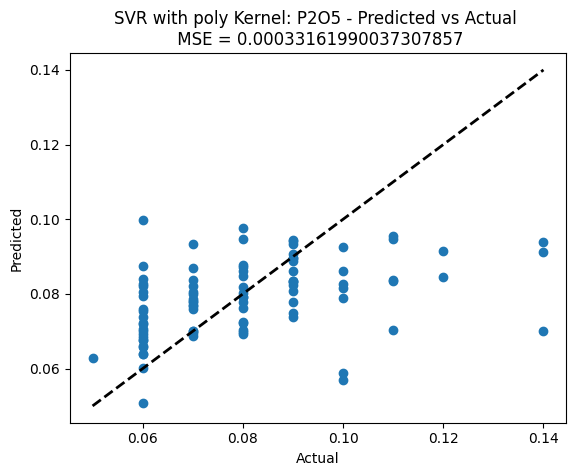

In [25]:
for col in concentration_data.columns[:]:
    y = concentration_data[col].values

    kernel = 'poly'
    svr = SVR(kernel=kernel)
    param_grid = {'C': [0.1, 1, 10], 'epsilon': [0.1, 0.01, 0.001], 'degree': [2, 3, 4]}

    grid_search = GridSearchCV(svr, param_grid, cv=5)
    grid_search.fit(x, y)
    best_params = grid_search.best_params_

    best_C = best_params['C']
    best_epsilon = best_params['epsilon']
    best_degree = best_params['degree']
    best_svr = SVR(kernel=kernel, C=best_C, epsilon=best_epsilon, degree=best_degree)

    loo = LeaveOneOut()
    y_pred_list = []
    for train_index, test_index in loo.split(x):
        X_train, X_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]
        best_svr.fit(X_train, y_train)
        y_pred = best_svr.predict(X_test)
        y_pred_list.append(y_pred)

    mse = mean_squared_error(y, y_pred_list)
    print("Mean Squared Error:", mse)

    plt.scatter(y, y_pred_list)
    plt.plot([min(y), max(y)], [min(y), max(y)], 'k--', lw=2)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(f'SVR with {kernel} Kernel: {col} - Predicted vs Actual \n MSE = {mse}')
    plt.show()



Root Mean Squared Error: 3.369417158929671


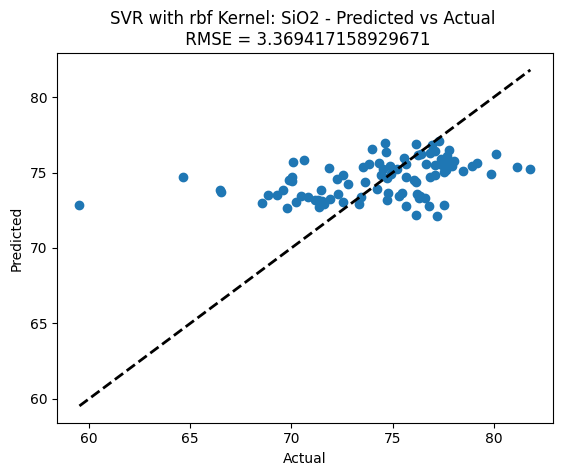

Root Mean Squared Error: 1.4397231721530677


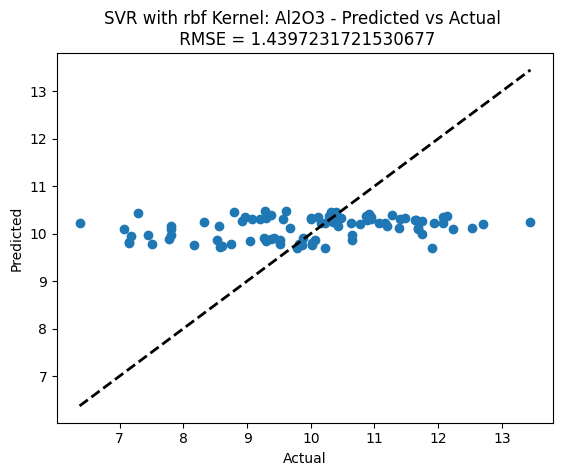

Root Mean Squared Error: 0.523539483078539


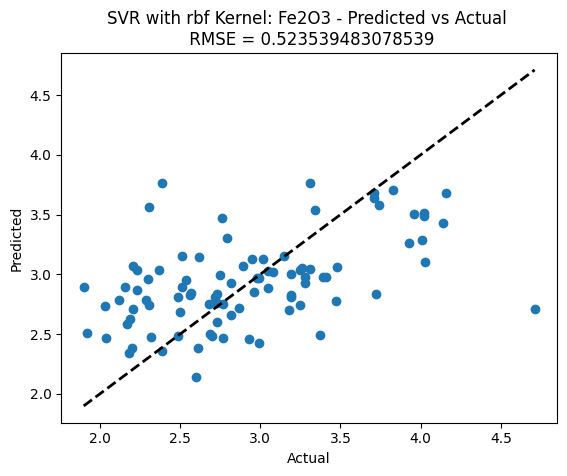

Root Mean Squared Error: 0.00731987461224913


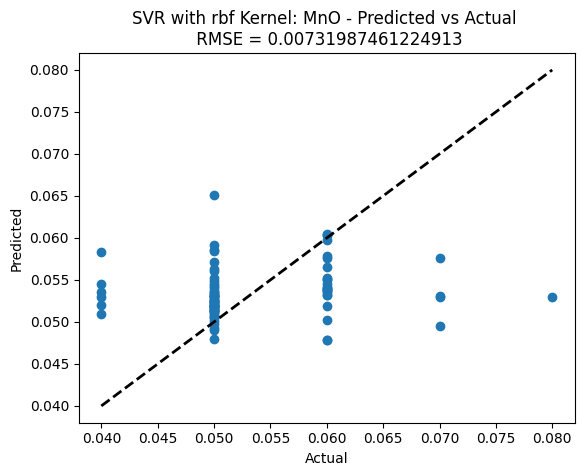

Root Mean Squared Error: 0.3207978790029427


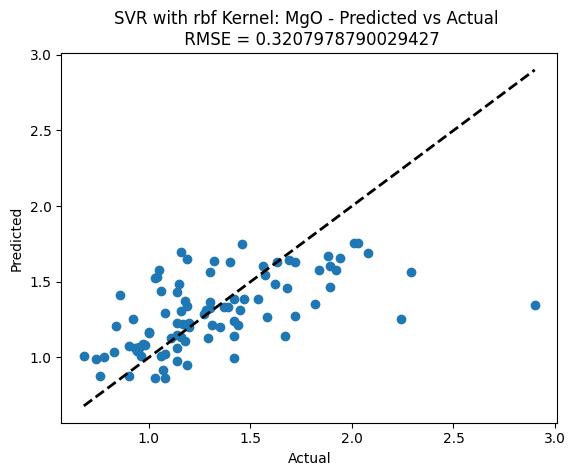

Root Mean Squared Error: 1.0033316396162315


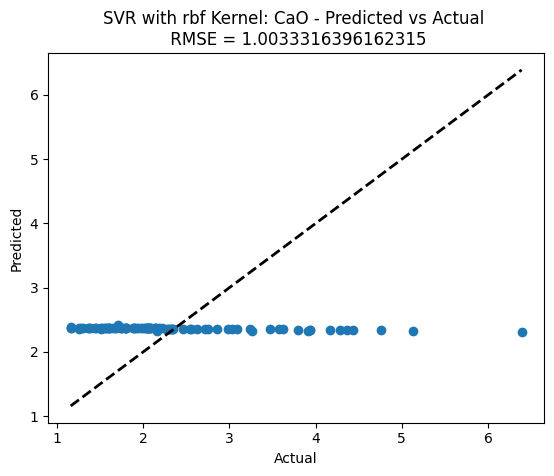

Root Mean Squared Error: 0.7450740621087671


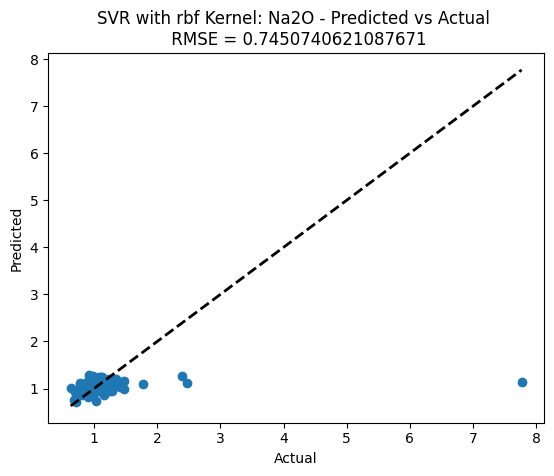

Root Mean Squared Error: 0.19783930347633163


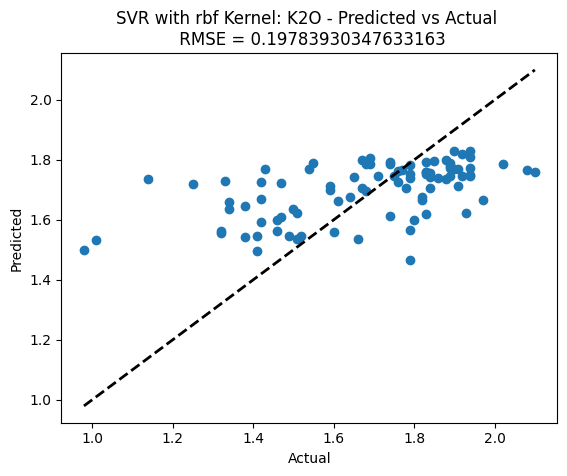

Root Mean Squared Error: 0.0794704134526053


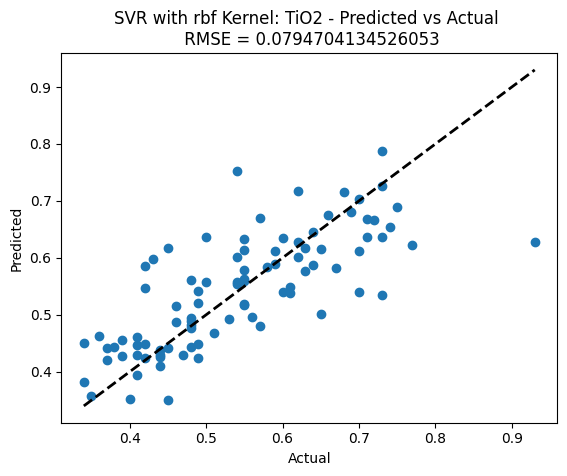

Root Mean Squared Error: 0.018849931930410478


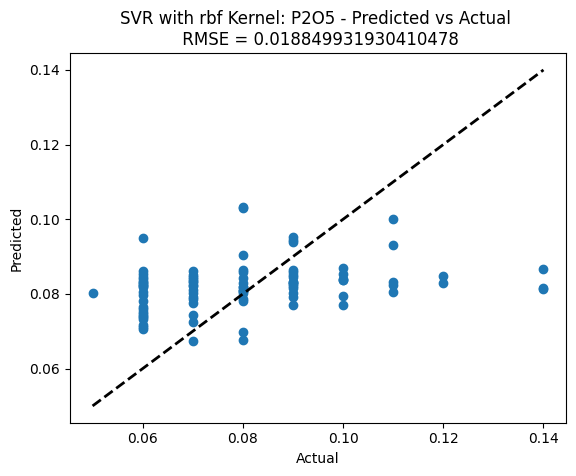

In [16]:
for col in concentration_data.columns[:]:
    y = concentration_data[col].values

    kernel = 'rbf'
    svr = SVR(kernel=kernel)
    param_grid = {'C': [0.1, 1, 10], 'epsilon': [0.1, 0.01, 0.001], 'gamma': [0.1, 1, 10]}

    grid_search = GridSearchCV(svr, param_grid, cv=5)
    grid_search.fit(x, y)
    best_params = grid_search.best_params_

    best_C = best_params['C']
    best_epsilon = best_params['epsilon']
    best_gamma = best_params['gamma']
    best_svr = SVR(kernel=kernel, C=best_C, epsilon=best_epsilon, gamma=best_gamma)

    loo = LeaveOneOut()
    y_pred_list = []
    for train_index, test_index in loo.split(x):
        X_train, X_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]
        best_svr.fit(X_train, y_train)
        y_pred = best_svr.predict(X_test)
        y_pred_list.append(y_pred)

    mse = mean_squared_error(y, y_pred_list)
    rmse = np.sqrt(mse)
    print("Root Mean Squared Error:", rmse)

    plt.scatter(y, y_pred_list)
    plt.plot([min(y), max(y)], [min(y), max(y)], 'k--', lw=2)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(f'SVR with {kernel} Kernel: {col} - Predicted vs Actual \n RMSE = {rmse}')
    plt.show()


Mean Squared Error: 1.940375189679363


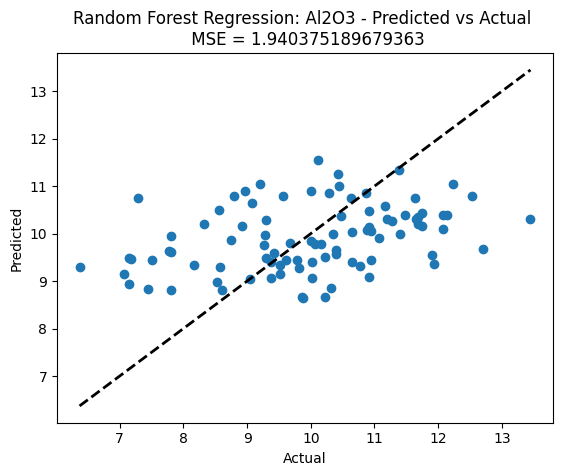

Mean Squared Error: 0.26155746807985203


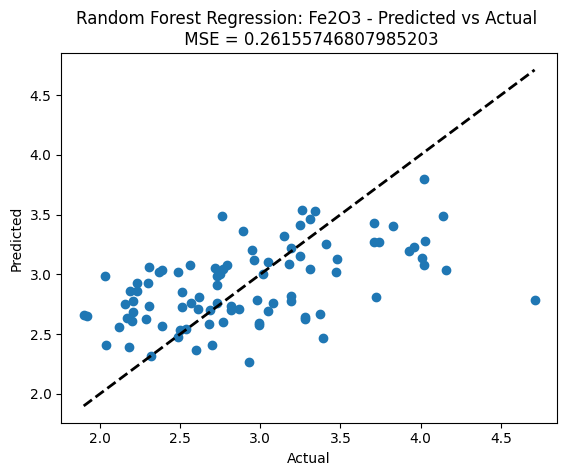

Mean Squared Error: 4.652890109890107e-05


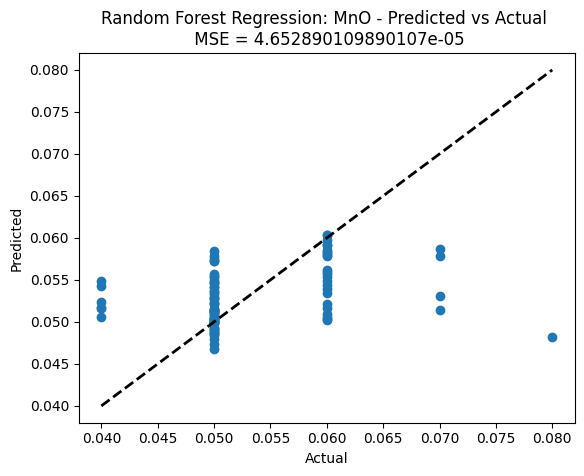

Mean Squared Error: 0.11028927724304313


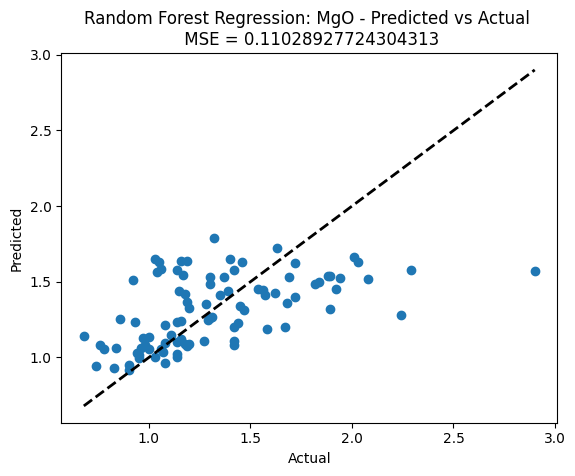

Mean Squared Error: 0.9421050400151523


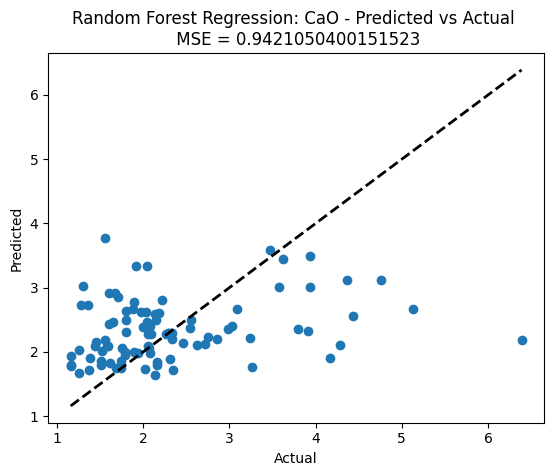

Mean Squared Error: 0.7061163333333333


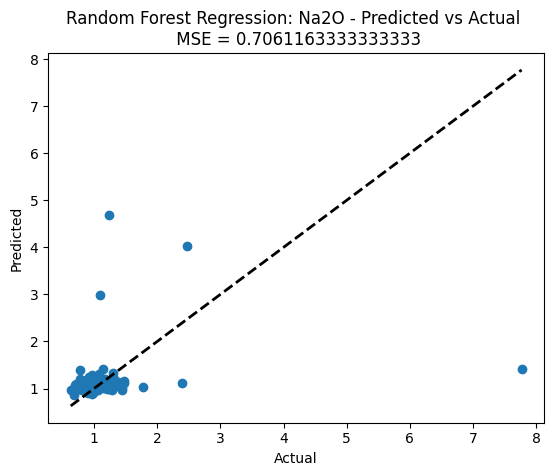

Mean Squared Error: 0.0472909096703297


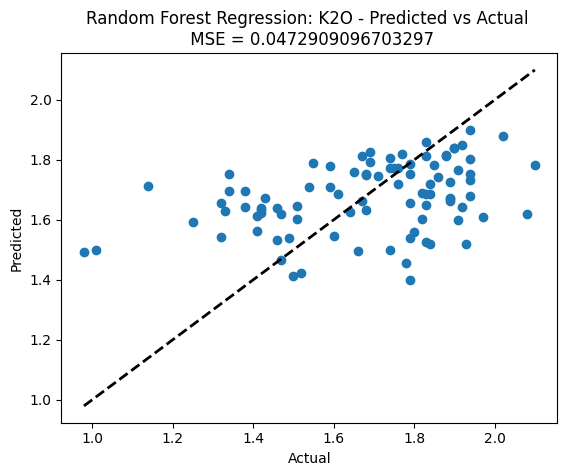

Mean Squared Error: 0.009072287252747257


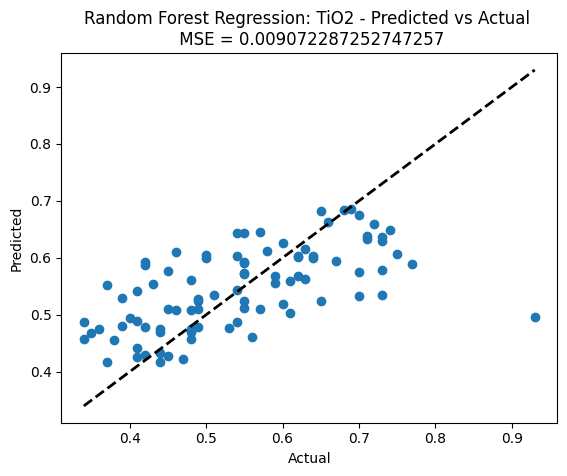

Mean Squared Error: 0.00036833634021564014


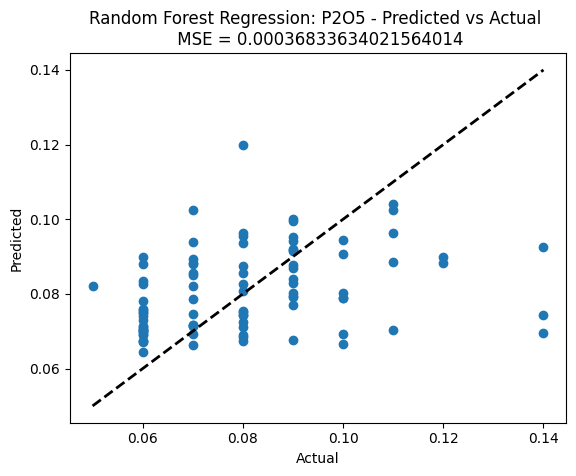

In [15]:
from sklearn.ensemble import RandomForestRegressor

for col in concentration_data.columns[1:]:
    y = concentration_data[col].values

    rf = RandomForestRegressor()

    param_grid = {'n_estimators': [30, 100, 500], 'max_depth': [None, 5, 10]}

    grid_search = GridSearchCV(rf, param_grid, cv=5)
    grid_search.fit(x, y)
    best_params = grid_search.best_params_

    best_n_estimators = best_params['n_estimators']
    best_max_depth = best_params['max_depth']
    best_rf = RandomForestRegressor(n_estimators=best_n_estimators, max_depth=best_max_depth)

    loo = LeaveOneOut()
    y_pred_list = []
    for train_index, test_index in loo.split(x):
        X_train, X_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]
        best_rf.fit(X_train, y_train)
        y_pred = best_rf.predict(X_test)
        y_pred_list.append(y_pred)

    mse = mean_squared_error(y, y_pred_list)
    print("Mean Squared Error:", mse)

    plt.scatter(y, y_pred_list)
    plt.plot([min(y), max(y)], [min(y), max(y)], 'k--', lw=2)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(f'Random Forest Regression: {col} - Predicted vs Actual \n MSE = {mse}')
    plt.show()


Mean Squared Error: 11.224490815448002


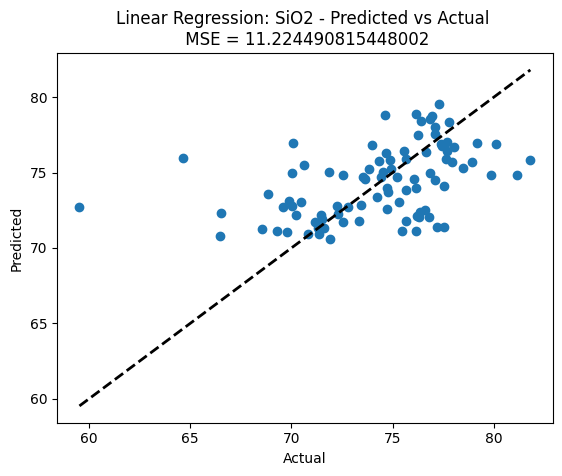

Mean Squared Error: 1.9571643374484309


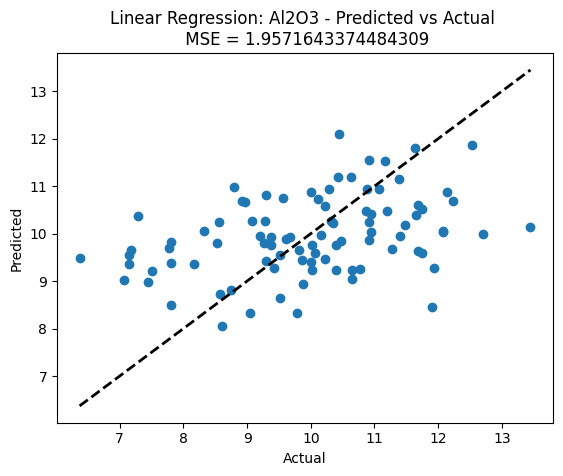

Mean Squared Error: 0.27147744515537486


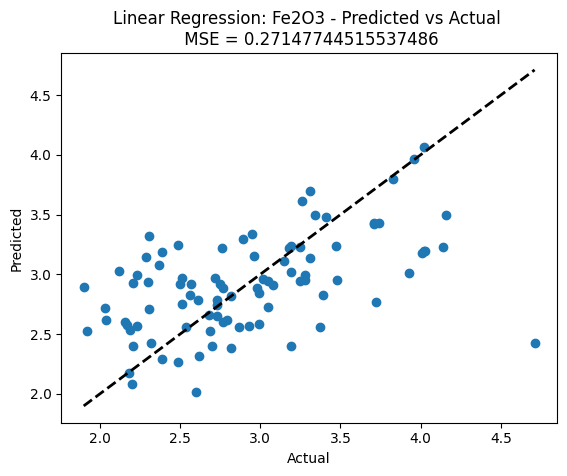

Mean Squared Error: 4.547958898631281e-05


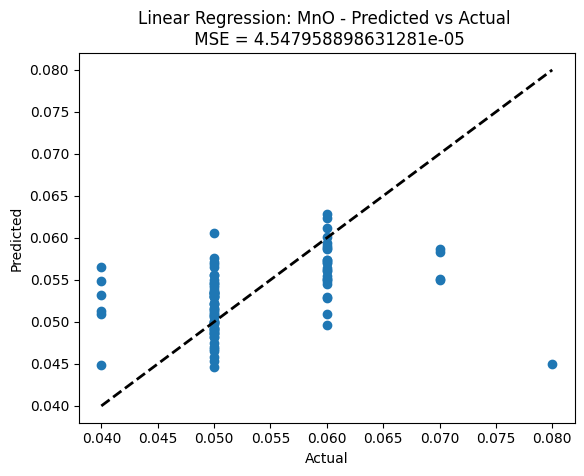

Mean Squared Error: 0.10562240371872782


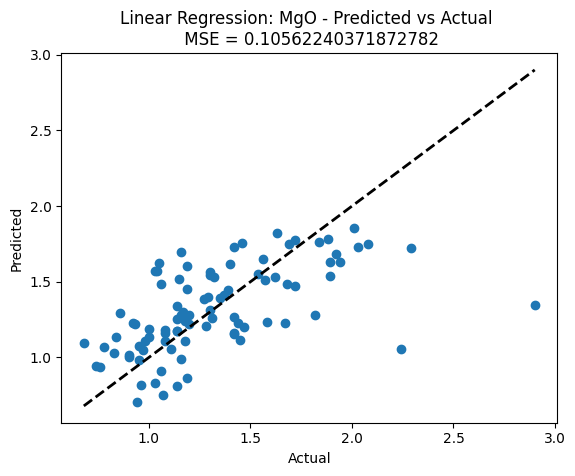

Mean Squared Error: 0.9362491006766501


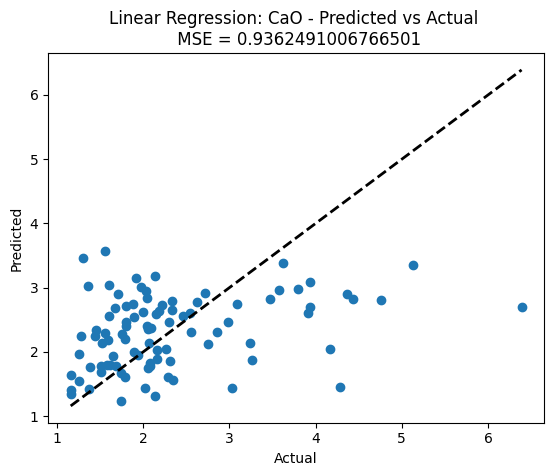

Mean Squared Error: 0.5903039504994929


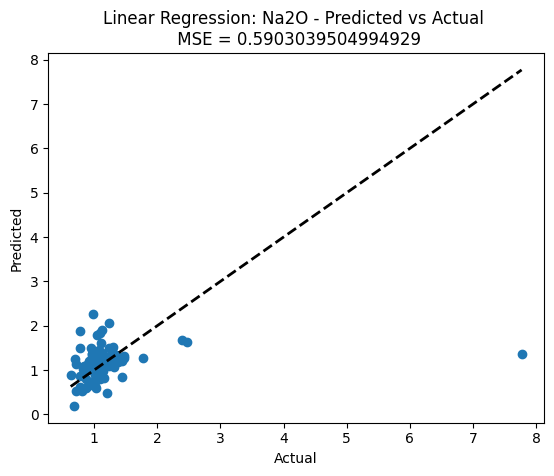

Mean Squared Error: 0.042876953721190825


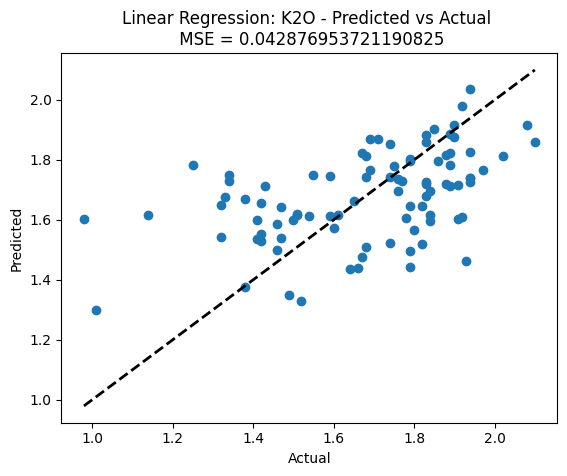

Mean Squared Error: 0.009177293921290389


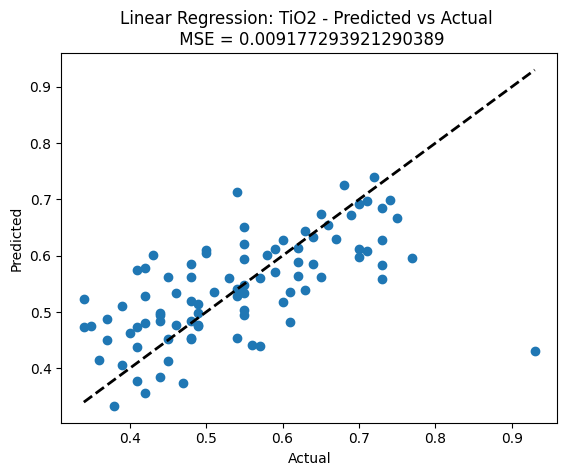

Mean Squared Error: 0.0003488421310560801


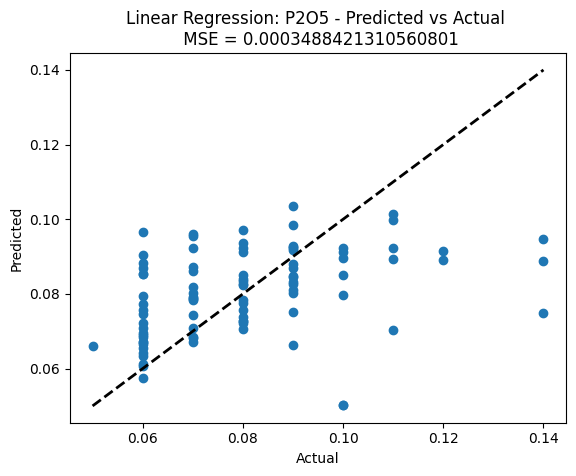

In [72]:
from sklearn.linear_model import LinearRegression

for col in concentration_data.columns[:]:
    y = concentration_data[col].values

    lr = LinearRegression()

    param_grid = {}  # No hyperparameters to tune for Linear Regression

    grid_search = GridSearchCV(lr, param_grid, cv=5)
    grid_search.fit(x, y)

    best_lr = grid_search.best_estimator_

    loo = LeaveOneOut()
    y_pred_list = []
    for train_index, test_index in loo.split(x):
        X_train, X_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]
        best_lr.fit(X_train, y_train)
        y_pred = best_lr.predict(X_test)
        y_pred_list.append(y_pred)

    mse = mean_squared_error(y, y_pred_list)
    print("Mean Squared Error:", mse)

    plt.scatter(y, y_pred_list)
    plt.plot([min(y), max(y)], [min(y), max(y)], 'k--', lw=2)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(f'Linear Regression: {col} - Predicted vs Actual \n MSE = {mse}')
    plt.show()
